In [ ]:
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import matplotlib.pyplot as plt  # For plotting the reward graph

# Check if a GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



In [ ]:
# Hyperparameters
learning_rate = 0.001
gamma = 0.995
epsilon = 1.0   #Initial probability for taking a random (exploratory) action
epsilon_decay = 0.995   #As training proceeds, epsilon decreases (less exploration) until it hits a minimum threshold.
epsilon_min = 0.01
batch_size =  128
num_episodes = 400  # Number of episodes to train
memory = deque(maxlen=50000)
#try with shorter buffer size

#after go to ppl

# Dots distribution in the grid
dots = [
    [1.73, 2.91], [1.33, 2.80], [1.25, 0.83], [2.59, 2.91], [1.64, 1.15],
    [2.01, 2.17], [1.60, 1.70], [0.47, 2.05], [1.81, 1.96], [1.64, 1.28],
    [2.01, 1.86], [2.94, 1.07], [1.26, 2.92], [1.56, 1.29], [2.03, 2.67],
    [1.89, 2.02], [1.76, 0.98], [1.74, 2.00], [1.69, 2.01], [2.45, 1.56],
    [0.39, 2.64], [3.27, 2.07], [3.27, 3.89], [2.89, 2.60], [0.60, 3.20]
]


In [ ]:
# Define the neural network for Q-value approximation
class QNetwork(nn.Module):      # nn.Model - inherited class - base class for all neural network modules in PyTorch.
    def __init__(self, input_size, output_size):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, 1024)  # fully connected linear layers
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, output_size)

        #try more options
        #

    def forward(self, state): # network architecture
        x = torch.relu(self.fc1(state))   #ReLU = Rectified Linear Unit
        x = torch.relu(self.fc2(x))
        return self.fc3(x)   # raw Q-value

# Initialize the environment (grid, disks, and dots)
class DiskEnvironment:
    def __init__(self, dots, grid_size=(4, 4), disk_radius=1.2):
        self.dots = np.array(dots)
        self.grid_size = grid_size
        self.disk_radius = disk_radius
        self.reset()

    def reset(self):
        # Reset the environment to initial positions
        self.disk1_pos = np.array([2.0, 2.0])  # Starting position of disk 1
        self.disk2_pos = np.array([2.0, 2.0])  # Starting position of disk 2
        return np.concatenate((self.disk1_pos, self.disk2_pos))

    def step(self, action):
        # Define the movement: 0 = stay, 1 = up, 2 = down, 3 = left, 4 = right
        movement = {
            0: np.array([0, 0]),
            1: np.array([0, 0.1]),
            2: np.array([0, -0.1]),
            3: np.array([-0.1, 0]),
            4: np.array([0.1, 0])
        }
        # Extract actions for both disks
        disk1_action = action // 5  # First disk's action
        disk2_action = action % 5   # Second disk's action

        # Update disk positions
        self.disk1_pos = np.clip(self.disk1_pos + movement[disk1_action], 0, 4)
        self.disk2_pos = np.clip(self.disk2_pos + movement[disk2_action], 0, 4)

        # Calculate reward
        reward = self.calculate_reward()

        # Return new state, reward, and done flag (if the episode ends)
        next_state = np.concatenate((self.disk1_pos, self.disk2_pos))
        done = False  # For simplicity, let's assume episodes don't have a fixed end
        return next_state, reward, done

    def calculate_reward(self):
        # Calculate how many dots are within the disks' coverage areas
        covered_dots = 0
        for dot in self.dots:
            if np.linalg.norm(dot - self.disk1_pos) <= self.disk_radius or np.linalg.norm(dot - self.disk2_pos) <= self.disk_radius:
                covered_dots += 1
        return covered_dots  # Reward is the number of covered dots


# Initialize Q-network and target network, and move them to the GPU if available
q_network = QNetwork(input_size=4, output_size=25).to(device)  # 4 inputs for the disk positions, 25 possible actions
target_network = QNetwork(input_size=4, output_size=25).to(device)
optimizer = optim.Adam(q_network.parameters(), lr=learning_rate)
loss_fn = nn.MSELoss()

# Initialize the environment
env = DiskEnvironment(dots)

# Replay buffer for experience replay
memory = deque(maxlen=20000)

# Track rewards for each episode
episode_rewards = []

# Function to select action using epsilon-greedy policy
def select_action(state, epsilon):
    if random.random() < epsilon:
        return random.randint(0, 24)  # Random action
    else:
        state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)  # Move state to GPU
        with torch.no_grad():
            q_values = q_network(state_tensor)
            return q_values.argmax().item()  # Action with max Q-value

# Store experiences in the replay buffer
def store_experience(memory, state, action, reward, next_state):
    memory.append((state, action, reward, next_state))

# Sample a batch from the memory
def sample_batch(memory, batch_size):
    return random.sample(memory, batch_size)

# Each experience contains a state, the action taken, the reward received, and the next state.
def train_q_network():
    if len(memory) < batch_size:
        return  # Not enough samples to train

    batch = sample_batch(memory, batch_size)
    states, actions, rewards, next_states = zip(*batch)

    # Move states and actions to GPU   - Converting Python lists/tuples into PyTorch tensors
    states_tensor = torch.FloatTensor(states).to(device)
    actions_tensor = torch.LongTensor(actions).unsqueeze(1).to(device)
    rewards_tensor = torch.FloatTensor(rewards).to(device)
    next_states_tensor = torch.FloatTensor(next_states).to(device)

    # Compute current Q-values
    current_q_values = q_network(states_tensor).gather(1, actions_tensor)   #pick out the Q–value corresponding to the action that was actually taken in each experience.

    # Compute target Q-values
    with torch.no_grad():
        max_next_q_values = target_network(next_states_tensor).max(1)[0]
        target_q_values = rewards_tensor + gamma * max_next_q_values      #immediate reward plus the discounted maximum Q–value of the next state

    # Compute loss and backpropagate
    loss = loss_fn(current_q_values.squeeze(), target_q_values)
    optimizer.zero_grad() # The computed loss how far network’s predictions are from the target values.
    loss.backward() # gradient descent (via backpropagation) to update the
    optimizer.step() # network weights to minimize this error.






Episode 1/400, Total Reward: 1980, Epsilon: 0.9950


/tmp/ipython-input-3320517204.py:108: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:253.)
  states_tensor = torch.FloatTensor(states).to(device)


Episode 2/400, Total Reward: 1973, Epsilon: 0.9900
Episode 3/400, Total Reward: 1761, Epsilon: 0.9851
Episode 4/400, Total Reward: 1906, Epsilon: 0.9801
Episode 5/400, Total Reward: 1785, Epsilon: 0.9752
Episode 6/400, Total Reward: 2097, Epsilon: 0.9704
Episode 7/400, Total Reward: 1612, Epsilon: 0.9655
Episode 8/400, Total Reward: 1892, Epsilon: 0.9607
Episode 9/400, Total Reward: 1799, Epsilon: 0.9559
Episode 10/400, Total Reward: 1955, Epsilon: 0.9511
Episode 11/400, Total Reward: 1809, Epsilon: 0.9464
Episode 12/400, Total Reward: 1979, Epsilon: 0.9416
Episode 13/400, Total Reward: 1777, Epsilon: 0.9369
Episode 14/400, Total Reward: 1908, Epsilon: 0.9322
Episode 15/400, Total Reward: 1886, Epsilon: 0.9276
Episode 16/400, Total Reward: 1894, Epsilon: 0.9229
Episode 17/400, Total Reward: 1899, Epsilon: 0.9183
Episode 18/400, Total Reward: 1896, Epsilon: 0.9137
Episode 19/400, Total Reward: 2006, Epsilon: 0.9092
Episode 20/400, Total Reward: 1678, Epsilon: 0.9046
Episode 21/400, Tota

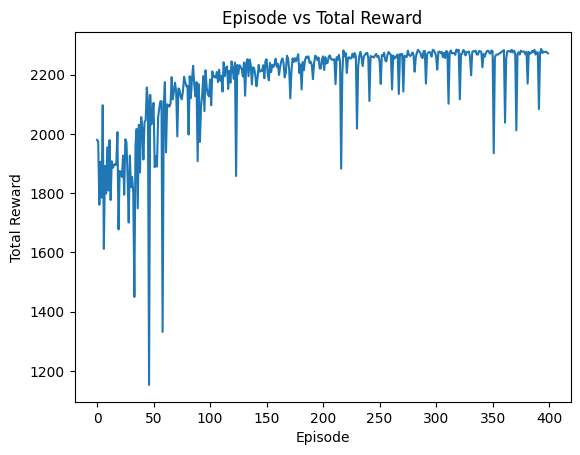

In [ ]:
# Training loop for multiple episodes
for episode in range(num_episodes):
    state = env.reset()
    total_reward = 0

    for step in range(100):
        action = select_action(state, epsilon)
        next_state, reward, done = env.step(action)
        store_experience(memory, state, action, reward, next_state)
        total_reward += reward
        state = next_state

        # Train the Q-network
        train_q_network()

        if done:
            break

    # Track the total reward for this episode
    episode_rewards.append(total_reward)

    # Decay epsilon
    if epsilon > epsilon_min:
        epsilon *= epsilon_decay

    # Print episode statistics
    print(f"Episode {episode + 1}/{num_episodes}, Total Reward: {total_reward}, Epsilon: {epsilon:.4f}")

    # Update target network weights
    if episode % 10 == 0:
        target_network.load_state_dict(q_network.state_dict())

print("Training completed!")

# Plot the episode vs reward graph
plt.plot(episode_rewards)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Episode vs Total Reward')
plt.show()


Testing the trained agent...
Step: 1, Action: 23, Reward: 19, Total Reward: 19
Step: 2, Action: 23, Reward: 20, Total Reward: 39
Step: 3, Action: 23, Reward: 20, Total Reward: 59
Step: 4, Action: 23, Reward: 21, Total Reward: 80
Step: 5, Action: 23, Reward: 22, Total Reward: 102
Step: 6, Action: 23, Reward: 23, Total Reward: 125
Step: 7, Action: 13, Reward: 23, Total Reward: 148
Step: 8, Action: 15, Reward: 23, Total Reward: 171
Step: 9, Action: 22, Reward: 23, Total Reward: 194
Step: 10, Action: 1, Reward: 23, Total Reward: 217
Step: 11, Action: 15, Reward: 23, Total Reward: 240
Step: 12, Action: 22, Reward: 23, Total Reward: 263
Step: 13, Action: 1, Reward: 23, Total Reward: 286
Step: 14, Action: 15, Reward: 23, Total Reward: 309
Step: 15, Action: 22, Reward: 23, Total Reward: 332
Step: 16, Action: 1, Reward: 23, Total Reward: 355
Step: 17, Action: 15, Reward: 23, Total Reward: 378
Step: 18, Action: 22, Reward: 23, Total Reward: 401
Step: 19, Action: 1, Reward: 23, Total Reward: 424


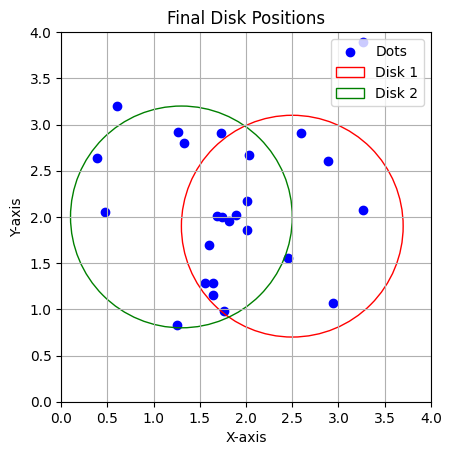

In [ ]:
import torch
import matplotlib.pyplot as plt

# Function to select action using the trained policy (no exploration)
def select_action_trained(state):
    state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)  # Move state to GPU
    with torch.no_grad():  # No gradient calculation needed for testing
        q_values = q_network(state_tensor)
        return q_values.argmax().item()  # Action with the highest Q-value

# Test the trained agent for a single episode and plot the disk positions
def test_trained_agent():
    state = env.reset()  # Reset the environment to start a new episode
    total_reward = 0
    steps = 0
    max_steps = 50  # Limit the steps per episode for testing

    # List to store the disk positions for plotting
    disk1_positions = []
    disk2_positions = []

    print("Testing the trained agent...")

    for step in range(max_steps):
        action = select_action_trained(state)  # Select the best action using the trained model
        next_state, reward, done = env.step(action)  # Apply the action in the environment
        total_reward += reward  # Accumulate the reward
        state = next_state  # Move to the next state
        steps += 1

        # Store disk positions for plotting
        disk1_positions.append(state[:2])  # Disk 1 position (x1, y1)
        disk2_positions.append(state[2:])  # Disk 2 position (x2, y2)

        # Print the details of each step
        print(f"Step: {steps}, Action: {action}, Reward: {reward}, Total Reward: {total_reward}")

        if done:
            break  # End the episode if the environment signals it's done

    # Print final positions of the disks
    print(f"Final position of Disk 1: {disk1_positions[-1]}")
    print(f"Final position of Disk 2: {disk2_positions[-1]}")
    print(f"Test completed. Total Reward after {steps} steps: {total_reward}")

    # Plot the final positions of the disks and the dots
    plot_disks_and_dots(disk1_positions[-1], disk2_positions[-1])

# Function to plot the disk positions and the dots
def plot_disks_and_dots(disk1_pos, disk2_pos):
    fig, ax = plt.subplots()

    # Plot the dots in the grid
    dots = np.array(env.dots)
    ax.scatter(dots[:, 0], dots[:, 1], color='blue', label="Dots")

    # Plot the disks as circles
    disk1_circle = plt.Circle(disk1_pos, env.disk_radius, color='red', fill=False, label="Disk 1")
    disk2_circle = plt.Circle(disk2_pos, env.disk_radius, color='green', fill=False, label="Disk 2")
    ax.add_artist(disk1_circle)
    ax.add_artist(disk2_circle)

    # Set the limits and labels for the plot
    ax.set_xlim(0, 4)
    ax.set_ylim(0, 4)
    ax.set_title('Final Disk Positions')
    ax.set_xlabel('X-axis')
    ax.set_ylabel('Y-axis')
    ax.legend()

    plt.gca().set_aspect('equal', adjustable='box')
    plt.grid(True)
    plt.show()

# Run the test
test_trained_agent()


Test

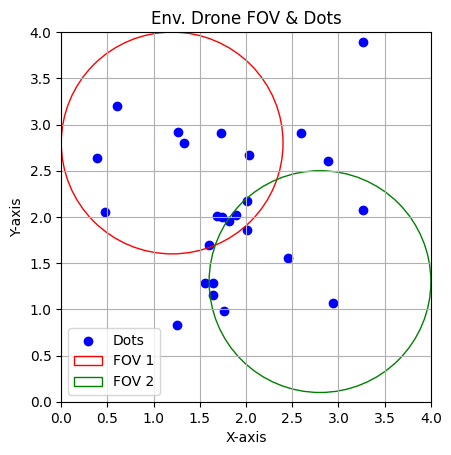

In [ ]:

# Function to plot the disk positions and the dots
def plot_disks_and_dots(disk1_pos, disk2_pos):
    fig, ax = plt.subplots()

    # Plot the dots in the grid
    dots = np.array(env.dots)
    ax.scatter(dots[:, 0], dots[:, 1], color='blue', label="Dots")

    # Plot the disks as circles
    disk1_circle = plt.Circle(disk1_pos, env.disk_radius, color='red', fill=False, label="FOV 1")
    disk2_circle = plt.Circle(disk2_pos, env.disk_radius, color='green', fill=False, label="FOV 2")
    ax.add_artist(disk1_circle)
    ax.add_artist(disk2_circle)

    # Set the limits and labels for the plot
    ax.set_xlim(0, 4)
    ax.set_ylim(0, 4)
    ax.set_title('Env. Drone FOV & Dots')
    ax.set_xlabel('X-axis')
    ax.set_ylabel('Y-axis')
    ax.legend()

    plt.gca().set_aspect('equal', adjustable='box')
    plt.grid(True)
    plt.show()
plot_disks_and_dots([1.2, 2.8], [2.8, 1.3])